In [1]:
import time
start_program = time.time()

import numpy as np 
import pandas as pd
import astropy.units as u
import multiprocessing as mp
from classy import Class
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import fsolve
from scipy import integrate
from scipy import interpolate
from scipy.special import j1
from functools import partial
import treecorr

import matplotlib.pyplot as plt
%matplotlib inline

### Angular bins for different tophat filter sizes (used for emulation)

In [2]:
theta_T_arcmins = 130

min_sep_tc = 5
max_sep_tc = 2*theta_T_arcmins - 10
nbins_tc = 15

## set the angular bins in which to compute the local 2PCFs
kk = treecorr.KKCorrelation(min_sep=min_sep_tc, max_sep=max_sep_tc, nbins=nbins_tc, sep_units='arcmin')
alpha_arcmins = kk.rnom
alpha_min_arcmins = kk.left_edges
alpha_max_arcmins = kk.right_edges

#np.savetxt("/Users/ahalder/work/Integrated_3PCF/Integrated_3PCF_theory/data/angular_bins/alpha_angles_arcmins_W"+str(theta_T_arcmins)+"_"+str(min_sep_tc)+"_"+str(max_sep_tc)+"_"+str(nbins_tc)+"_bins.tab", alpha_arcmins.T)
#np.savetxt("/Users/ahalder/work/Integrated_3PCF/Integrated_3PCF_theory/data/angular_bins/alpha_min_angles_arcmins_W"+str(theta_T_arcmins)+"_"+str(min_sep_tc)+"_"+str(max_sep_tc)+"_"+str(nbins_tc)+"_bins.tab", alpha_min_arcmins.T)
#np.savetxt("/Users/ahalder/work/Integrated_3PCF/Integrated_3PCF_theory/data/angular_bins/alpha_max_angles_arcmins_W"+str(theta_T_arcmins)+"_"+str(min_sep_tc)+"_"+str(max_sep_tc)+"_"+str(nbins_tc)+"_bins.tab", alpha_max_arcmins.T)


# Halo mass functions from Ryuichi Takahashi for the T17 simulations

In [3]:
z_HMF = np.array([0.076, 0.238, 0.413, 0.608, 0.827, 1.078, 1.370, 1.714, 2.130, 2.638])
sim_box_size = np.array([450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500])

box_idx_with_min_bin_number = 0
min_bin_number = 99999
for i in range(sim_box_size.size):
    M_halo_bins = np.loadtxt('../../../data/simulations/Takahashi/HMF/hc_mean_mlogbin0.05_'+str(sim_box_size[i])+'Mpc_001.txt', usecols=[0])
    print('Box size '+str(sim_box_size[i])+' with '+str(M_halo_bins.size)+' bins')
    if (M_halo_bins.size < min_bin_number):
        box_idx_with_min_bin_number = i
        min_bin_number = M_halo_bins.size

print('Box with minimum number of bins '+str(sim_box_size[box_idx_with_min_bin_number]))
M_halo_bins = np.loadtxt('../../../data/simulations/Takahashi/HMF/hc_mean_mlogbin0.05_'+str(sim_box_size[box_idx_with_min_bin_number])+'Mpc_001.txt', usecols=[0])
print(M_halo_bins.size)
M_halos_HMF = M_halo_bins[1:M_halo_bins.size]
print(M_halos_HMF.size)
N_halos_HMF_z = np.zeros((z_HMF.size, M_halos_HMF.size))
print(N_halos_HMF_z.shape)
for i in range(sim_box_size.size):
    print('Box size '+str(sim_box_size[i]))
    cum_number = np.loadtxt('../../../data/simulations/Takahashi/HMF/hc_mean_mlogbin0.05_'+str(sim_box_size[i])+'Mpc_001.txt', usecols=[1])
    N_halos_HMF_z[i] = cum_number[:M_halos_HMF.size] - cum_number[1:M_halos_HMF.size+1]

n_halos_HMF_z =  (N_halos_HMF_z.T / sim_box_size**3 ).T

Box size 450 with 110 bins
Box size 900 with 113 bins
Box size 1350 with 108 bins
Box size 1800 with 107 bins
Box size 2250 with 106 bins
Box size 2700 with 104 bins
Box size 3150 with 102 bins
Box size 3600 with 98 bins
Box size 4050 with 93 bins
Box size 4500 with 90 bins
Box with minimum number of bins 4500
90
89
(10, 89)
Box size 450
Box size 900
Box size 1350
Box size 1800
Box size 2250
Box size 2700
Box size 3150
Box size 3600
Box size 4050
Box size 4500


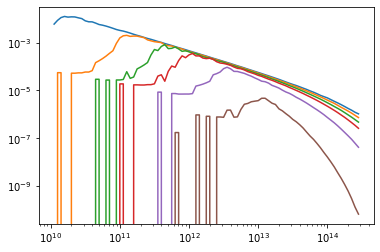

In [94]:
plt.plot(M_halos_HMF, n_halos_HMF_z[0])
plt.plot(M_halos_HMF, n_halos_HMF_z[1])
plt.xscale('log')
plt.yscale('log')

In [97]:
n_halos_HMF_z.shape

(10, 89)

In [4]:
from scipy import interpolate
x = M_halos_HMF
y = z_HMF
z = n_halos_HMF_z
f = interpolate.interp2d(x, y, z, kind='cubic')

In [6]:
M_halos_HMF_linear = np.linspace(M_halos_HMF.min(),M_halos_HMF.max(),5000)
M_halos_HMF_linear

array([1.12202000e+10, 6.75968313e+10, 1.23973463e+11, ...,
       2.81725247e+14, 2.81781623e+14, 2.81838000e+14])

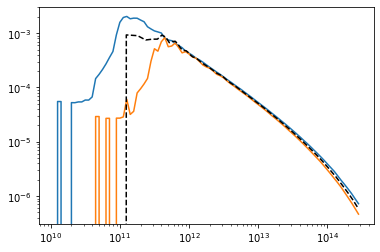

In [12]:
plt.plot(M_halos_HMF, n_halos_HMF_z[1])
plt.plot(M_halos_HMF, n_halos_HMF_z[2])
plt.plot(M_halos_HMF_linear, f(M_halos_HMF_linear, (z_HMF[1]+z_HMF[2])/2), c='k', ls='dashed')
plt.xscale('log')
plt.yscale('log')

In [15]:
f(1e16, (z_HMF[1]+z_HMF[2])/2)

array([5.83886244e-07])

In [16]:
np.log10(2e14)

14.301029995663981

In [8]:
h = 0.7
dat = np.array([M_halos_HMF_linear/h, f(M_halos_HMF_linear, 0.31)*h**3])
np.savetxt("/Users/ahalder/work/Integrated_3PCF/Integrated_3PCF_theory/data/miscellaneous/HMF/T17_HMF_z_0.31.tab", dat.T)

In [99]:
f(M_halos_HMF, z_HMF[0])

array([6.02798354e-03, 8.65075446e-03, 1.13218107e-02, 1.26320988e-02,
       1.18364883e-02, 1.21459534e-02, 1.20351166e-02, 1.10623868e-02,
       1.02582167e-02, 8.27544582e-03, 7.53657064e-03, 7.48554184e-03,
       6.64186557e-03, 5.78688615e-03, 5.42748971e-03, 4.97679012e-03,
       4.49382716e-03, 4.01986283e-03, 3.57344307e-03, 3.27528121e-03,
       3.06545953e-03, 2.79934156e-03, 2.52115226e-03, 2.25251029e-03,
       2.03478738e-03, 1.85327846e-03, 1.66661180e-03, 1.50650206e-03,
       1.38161866e-03, 1.25037037e-03, 1.12656241e-03, 1.02463649e-03,
       9.22052126e-04, 8.37958848e-04, 7.62436214e-04, 6.84510288e-04,
       6.17316872e-04, 5.61185185e-04, 5.08060357e-04, 4.57272977e-04,
       4.12170096e-04, 3.72718793e-04, 3.37108368e-04, 3.03648834e-04,
       2.74578875e-04, 2.47242798e-04, 2.22639232e-04, 2.01558299e-04,
       1.81541838e-04, 1.63566529e-04, 1.47906722e-04, 1.33443073e-04,
       1.19584088e-04, 1.07297668e-04, 9.70491084e-05, 8.71242798e-05,
      

In [85]:
(N_halos_HMF_z.T/(sim_box_size**3)).T.shape

(10, 89)

In [81]:
sim_box_size**3

array([   91125000,   729000000,  2460375000,  5832000000, 11390625000,
       19683000000, 31255875000, 46656000000, 66430125000, 91125000000])

In [58]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [62]:
a = np.ones(5)
a

array([1., 1., 1., 1., 1.])

In [78]:
a[:a.size-1]-a[1:a.size]

array([0., 0., 0., 0.])

In [44]:
import itertools
import numpy as np

In [74]:
iZ_correlation_name_list = ['app', 'amm', 'att', 'agg', 'gpp', 'gmm', 'gtt', 'ggg']

if ('amm9' in iZ_correlation_name_list):
    print('lol')

In [81]:
np.unique(np.logspace(np.log10(2), np.log10(15000), 113).astype(int))

array([    2,     3,     4,     5,     6,     7,     8,     9,    10,
          11,    12,    13,    14,    15,    17,    18,    20,    21,
          23,    25,    27,    30,    32,    35,    38,    41,    44,
          48,    52,    56,    61,    66,    72,    78,    84,    91,
          99,   107,   116,   125,   136,   147,   159,   173,   187,
         203,   219,   238,   257,   279,   302,   327,   354,   384,
         416,   450,   487,   528,   572,   619,   671,   726,   786,
         852,   922,   999,  1082,  1172,  1269,  1374,  1488,  1611,
        1745,  1890,  2047,  2216,  2400,  2599,  2815,  3048,  3301,
        3575,  3871,  4192,  4540,  4917,  5324,  5766,  6244,  6762,
        7323,  7930,  8588,  9300, 10071, 10906, 11811, 12790, 13851,
       15000])

In [71]:
b1 = 3.0
0.412 - 2.143*b1 + 0.929*b1**2 + 0.008*b1**3

2.5600000000000014

In [15]:
a = np.arange(1,5)
b = np.arange(7,9)
c = ['lol']

In [16]:
list(itertools.product(a,b,c))

[(1, 7, 'lol'),
 (1, 8, 'lol'),
 (2, 7, 'lol'),
 (2, 8, 'lol'),
 (3, 7, 'lol'),
 (3, 8, 'lol'),
 (4, 7, 'lol'),
 (4, 8, 'lol')]

In [63]:
def sum_a_b(params):
    x = params[0]
    y = params[1]
    return x+y

In [66]:
x_and_y_list = list(itertools.product(a, b))
pool = mp.Pool(processes=mp.cpu_count()-1)
result = pool.map(sum_a_b, x_and_y_list)
result = np.array(result)

Process SpawnPoolWorker-19:
Process SpawnPoolWorker-20:
Traceback (most recent call last):
  File "/Users/ahalder/software/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ahalder/software/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ahalder/software/miniconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/ahalder/software/miniconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'sum_a_b' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Users/ahalder/software/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ahalder/software/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **

KeyboardInterrupt: 

In [34]:
c = [(x, y, 100) for x, y in list(itertools.product(a,b))]

c

[(1, 7, 100),
 (1, 8, 100),
 (2, 7, 100),
 (2, 8, 100),
 (3, 7, 100),
 (3, 8, 100),
 (4, 7, 100),
 (4, 8, 100)]

In [31]:
def get_masses(delta_m_squared_atm, delta_m_squared_sol, sum_masses, hierarchy):
    # delta_m_squared_atm, delta_m_squared_sol are constraints of square differences of neutrino masses from oscillation experiments
    # massless neutrino case should be considered separately
    if sum_masses == 0.0:
        m1 = 0.0
        m2 = 0.0
        m3 = 0.0
        return m1, m2, m3
    
    # any string containing letter 'n' will be considered as refering to normal hierarchy
    if 'n' in hierarchy.lower():
        # delta_m_squared_atm = m_3^2 - (m_1^2 + m_2^2)/2
        # delta_m_squared_sol = m_2^2 - m_1^2
        m1_func = lambda m1, M_tot, d_m_sq_atm, d_m_sq_sol: M_tot**2. + 0.5*d_m_sq_sol - d_m_sq_atm + m1**2. - 2.*M_tot*m1 - 2.*M_tot*(d_m_sq_sol+m1**2.)**0.5 + 2.*m1*(d_m_sq_sol+m1**2.)**0.5
        m1, opt_output, success, output_message = fsolve(m1_func, sum_masses/3.,(sum_masses,delta_m_squared_atm,delta_m_squared_sol), full_output=True)
        m1 = m1[0]
        m2 = (delta_m_squared_sol + m1**2.)**0.5
        m3 = (delta_m_squared_atm + 0.5*(m2**2. + m1**2.))**0.5
        return m1, m2, m3
    else:
        # Inverted hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_IH and deletes M_tot_IH
        #delta_m_squared_atm = -m_3^2 + (m_1^2 + m_2^2)/2
        #delta_m_squared_sol = m_2^2 - m_1^2
        delta_m_squared_atm = -delta_m_squared_atm
        m1_func = lambda m1, M_tot, d_m_sq_atm, d_m_sq_sol: M_tot**2. + 0.5*d_m_sq_sol - d_m_sq_atm + m1**2. - 2.*M_tot*m1 - 2.*M_tot*(d_m_sq_sol+m1**2.)**0.5 + 2.*m1*(d_m_sq_sol+m1**2.)**0.5
        m1, opt_output, success, output_message = fsolve(m1_func, sum_masses/3.,(sum_masses,delta_m_squared_atm,delta_m_squared_sol),full_output=True)
        m1 = m1[0]
        m2 = (delta_m_squared_sol + m1**2.)**0.5
        m3 = (delta_m_squared_atm + 0.5*(m2**2. + m1**2.))**0.5
        return m1, m2, m3
    

############### function to compute density parameter of massive neutrinos ######
def Mnu2omeganu(sum_masses, matter_density):
    # the neutrino mass constraints come from the MassiveNuS paper by Liu et al.
    m1, m2, m3 = get_masses(2.5e-3, 7.37e-5, sum_masses, 'NH') 
    mnu_arr = np.array([m1, m2, m3])* u.eV
    cosmo = FlatLambdaCDM(H0=h*100, Om0=matter_density, Neff=3.046, m_nu=mnu_arr, Ob0=omega_b/(h**2), Tcmb0=2.7255)
    return cosmo.Onu0*(h**2)


#### Read in multipole numbers prepared for power spectrum computation ######
#ell = np.loadtxt("ell_array_100.txt", usecols=(0))
#ell = np.loadtxt("ell_array_30.txt", usecols=(0))
#ell = np.logspace(np.log10(2), np.log10(15000), 90) # directly use logspace in multipole values without integers
#ell = np.logspace(np.log10(2), np.log10(15000), 30)
ell = np.logspace(np.log10(2), np.log10(15000), 60)

'''
#### MICE cosmology ###
omega_b = 0.02156 # Omega_b*h*h
omega_cdm = 0.10094 # Omega_cdm*h*h
h = 0.7
sigma8 = 0.8
n_s = 0.95
Mv = 0.0
'''

#### Takahashi cosmology ####
omega_b = 0.02254 # Omega_b*h*h
omega_cdm = 0.11417 # Omega_cdm*h*h
h = 0.7
sigma8 = 0.82
n_s = 0.97
Mv = 0.0



'''
##shell-correction fitting parameters for Takahashi simulation##
alpha1 = 1.3063
alpha2 = 1.1475
alpha3 = 0.62793
c1 = 9.5171e-4
c2 = 5.1543e-3
'''
'''
### MassiveNuS cosmology ###
omega_b = 0.02254  #Liu's input, we have 0.02254 and 0.02254 is also the value in Takahashi simulation
Omega_m = 0.3
A_s = 2.1e-9
n_s = 0.97 #n_s value for MassiveNuS
h = 0.7
Lbox = 512/h #simulaion box size in Mpc
##shell-correction fitting parameters for MassiveNuS##
a1 = 1.3606
a2 = 1.2674
a3 = 0.7028
c1 = 2.2041e-3
c2 = 1.0861e-2
'''

nonlinear_model = "hmcode"
# maximum wave number used in generating CLASS object but in real physical quantity we do not approach this limit, just like "z_max_pk"
kmax_pk = 1000.0
kmax = 200.0 # better to change to 200 1/Mpc
# source redshift bins
zs = [0.5739, 1.0334] #for Takahashi simulation
#zs = [0.993] #for MICE simulation
# number of source redshifts
n = len(zs)
# number of redshift bins used in the 4d integration of int-bispectrum
N_integ = 50
# number of redshift bins used in the LOS projection
N_los = 100
# critical wave vector value for box size correction
#L_box = np.array([1800/h, 2700/h]) # box size for the two corresponding source redshifts in Takahashi simulation
#k_box = 2*np.pi/L_box
# account for the finite resolution of sky-maps
#N_side = 4096 # N_side for Takahashi simulation
#l_res = 1.6 * N_side
#damping = 1/(1+(ell/l_res)**2)
z_max = 2.1

#######################CLASS setup for both linear and non-linear power spectrum#####################

if Mv == 0.0:
    commonsettings_nl  = {
                  'N_ur':3.046,
                  'N_ncdm':0,
                  'output':'mPk',
                  'P_k_max_1/Mpc':kmax_pk,
                  # The next line should be uncommented fgor higher precision (but significantly slower running)
                  #'ncdm_fluid_approximation':3,
                  # You may uncomment this line to get more info on the ncdm sector from Class:
                  #'background_verbose':10,
                  'background_verbose':0,
                  # omega_b here actually means Omega_b * h**2
                  'omega_b':omega_b,
                  'h':h,
                  #'n_s':n_s,
                  'A_s':2.19685e-9, 
                  #'sigma8': sigma8,
                  #'omega_cdm':Omega_m*(h**2)-omega_b, #0.12470 Liu's input for massless neutrino and Omega_m=0.3 case 
                  'omega_cdm': omega_cdm,
                  'Omega_k':0.0,
                  'Omega_fld':0.0,
                  'Omega_scf':0.0,
                  'YHe':0.24, #'BBN', 0.24 Liu's input
                  'z_max_pk':3.5,
                  'non linear':nonlinear_model,
                  'write warnings':'yes'
                 }
    commonsettings_l  = {
                  'N_ur':3.046,
                  'N_ncdm':0,
                  'output':'mPk',
                  'P_k_max_1/Mpc':kmax_pk,
                  # The next line should be uncommented fgor higher precision (but significantly slower running)
                  #'ncdm_fluid_approximation':3,
                  # You may uncomment this line to get more info on the ncdm sector from Class:
                  #'background_verbose':10,
                  'background_verbose':0,
                  # omega_b here actually means Omega_b * h**2
                  'omega_b':omega_b,
                  'h':h,
                  'n_s':n_s,
                  #'A_s':A_s, 
                  'sigma8': sigma8,
                  #'omega_cdm':Omega_m*(h**2)-omega_b, #0.12470 Liu's input for massless neutrino and Omega_m=0.3 case 
                  'omega_cdm': omega_cdm,
                  'Omega_k':0.0,
                  'Omega_fld':0.0,
                  'Omega_scf':0.0,
                  'YHe':0.24, #'BBN', 0.24 Liu's input
                  'z_max_pk':3.5,
                  'write warnings':'yes'
                 }
    
else:
    m1, m2, m3 = get_masses(2.5e-3,7.37e-5, Mv, 'NH')
    omega_nu = Mnu2omeganu(Mv, Omega_m)
    commonsettings_nl  = {
                  'N_ur':0.00641,
                  'N_ncdm':3,
                  'output':'mPk',
                  'P_k_max_1/Mpc':kmax_pk,
                  # The next line should be uncommented fgor higher precision (but significantly slower running)
                  #'ncdm_fluid_approximation':3,
                  # You may uncomment this line to get more info on the ncdm sector from Class:
                  #'background_verbose':10,
                  'background_verbose':0,
                  'omega_b':omega_b,
                  #'omega_cdm':Omega_m*(h**2)-(omega_b+omega_nu), #0.12362 Liu's input for massive neutrinos and Omega_m=0.3
                  'omega_cdm': omega_cdm,
                  'm_ncdm':str(m1)+','+str(m2)+','+str(m3),
                  'h':h,
                  'n_s':n_s,
                  #'A_s':A_s, 
                  'sigma8': sigma8,
                  'Omega_k':0.0,
                  'Omega_fld': 0.0,
                  'Omega_scf': 0.0,          
                  'YHe':0.24, #'BBN', 0.24 Liu's input
                  'z_max_pk':3.5,
                  #'nonlinear_verbose':10,
                  'non linear':nonlinear_model,
                  'write warnings':'yes'
                 }
    commonsettings_l  = {
                  'N_ur':0.00641,
                  'N_ncdm':3,
                  'output':'mPk',
                  'P_k_max_1/Mpc':kmax_pk,
                  # The next line should be uncommented fgor higher precision (but significantly slower running)
                  #'ncdm_fluid_approximation':3,
                  # You may uncomment this line to get more info on the ncdm sector from Class:
                  #'background_verbose':10,
                  'background_verbose':0,
                  'omega_b':omega_b,
                  #'omega_cdm':Omega_m*(h**2)-(omega_b+omega_nu), #0.12362 Liu's input for massive neutrinos and Omega_m=0.3
                  'omega_cdm': omega_cdm,
                  'm_ncdm':str(m1)+','+str(m2)+','+str(m3),
                  'h':h,
                  'n_s':n_s,
                  #'A_s':A_s, 
                  'sigma8': sigma8,
                  'Omega_k':0.0,
                  'Omega_fld': 0.0,
                  'Omega_scf': 0.0,          
                  'YHe':0.24, #'BBN', 0.24 Liu's input
                  'z_max_pk':3.5,
                  'write warnings':'yes'
                 }

#### CLASS computation for both linear and non-linear power spectrum #####
class_start = time.time()

#Cosmo_l = Class()
#Cosmo_l.set(commonsettings_l)
#Cosmo_l.compute()

Cosmo_nl = Class()
Cosmo_nl.set(commonsettings_nl)
Cosmo_nl.compute()


In [32]:
Cosmo_nl.sigma8()

0.8200008119577091

In [33]:
Cosmo_nl.Hubble(0)

0.00023349486663870643

In [34]:
H_z = interpolate.interp1d(Cosmo_nl.get_background()['z'], Cosmo_nl.get_background()['H [1/Mpc]'], kind='cubic', fill_value=0.0)

In [35]:
H_z(0)

array(0.00023349)

In [38]:
z_array_los = np.linspace(0.01, 2.0, 200)

In [39]:
z_array_los

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.

In [42]:
dz = (z_array_los[-1]-z_array_los[0]) / (int(z_array_los.shape[0]) - 1)

dz

0.01

In [41]:
z_array_los.shape

(200,)

In [41]:
import tensorflow as tf

In [82]:
a = np.array([1,2,3,4])

In [85]:
tf.cast(tf.broadcast_to(0.4, shape=(tf.shape(a)[0], 1)), dtype=tf.float64)[False,True,False,True]

InvalidArgumentError: Value for attr 'Index' of bool is not in the list of allowed values: int32, int64
	; NodeDef: {{node StridedSlice}}; Op<name=StridedSlice; signature=input:T, begin:Index, end:Index, strides:Index -> output:T; attr=T:type; attr=Index:type,allowed=[DT_INT32, DT_INT64]; attr=begin_mask:int,default=0; attr=end_mask:int,default=0; attr=ellipsis_mask:int,default=0; attr=new_axis_mask:int,default=0; attr=shrink_axis_mask:int,default=0> [Op:StridedSlice] name: strided_slice/

In [15]:
def eta_0_val(c_min):
    return 1.03-0.11*c_min

#### Takahashi cosmology (fiducial) ####
#omega_b = 0.02254 # Omega_b*h*h i.e. the physical baryon density 
#omega_cdm = 0.11417 # Omega_cdm*h*h i.e. the physical cdm density 
Omega_b = 0.046
Omega_cdm = 0.233
#Omega_cdm = 0.45-Omega_b
h = 0.7
sigma8 = 0.82
n_s = 0.97
#w_0 = -1.0
w_0 = -1.8
w_a = 0.0
c_min = 1.8
#eta_0 = 0.603 # emu_dmonly (fiducial)
eta_0 = eta_0_val(c_min)
Mv = 0.0

'''
Omega_b = 0.0448 
Omega_cdm = 0.2648 - Omega_b 
h = 0.71
sigma8 = 0.801
n_s = 0.963
Mv = 0.0
A_s = 2.165e-9
'''

omega_b = Omega_b * h * h
omega_cdm = Omega_cdm * h * h

if Mv == 0.0:
    commonsettings_nl  = {
                # The next line should be uncommented fgor higher precision (but significantly slower running)
                #'ncdm_fluid_approximation':3,
                # You may uncomment this line to get more info on the ncdm sector from Class:
                #'background_verbose':10,
                # omega_b here actually means Omega_b*h*h
                'h':h,
                'omega_b':omega_b,
                'omega_cdm': omega_cdm,
                'n_s':n_s,
                'sigma8': sigma8,
                #'A_s': A_s,
                'Omega_Lambda':0.0,
                'fluid_equation_of_state':'CLP',
                'w0_fld':w_0,
                'wa_fld':w_a,
                'output':'mPk',
                'P_k_max_1/Mpc':70,
                'z_max_pk':3.0,
                'non linear':'hmcode',
                'eta_0':eta_0,
                'c_min':c_min,
                #'write warnings':'yes'
                }
    
else:
    m1, m2, m3 = get_masses(2.5e-3,7.37e-5, Mv, 'NH')
    omega_nu = Mnu2omeganu(Mv, Omega_m)
    commonsettings_nl  = {
                'N_ur':0.00641,
                'N_ncdm':3,
                'output':'mPk',
                'P_k_max_1/Mpc':constants._k_max_pk_,
                # The next line should be uncommented fgor higher precision (but significantly slower running)
                #'ncdm_fluid_approximation':3,
                # You may uncomment this line to get more info on the ncdm sector from Class:
                #'background_verbose':10,
                'background_verbose':0,
                'omega_b':omega_b,
                'omega_cdm':Omega_m*(h**2)-(omega_b+omega_nu), #0.12362 Liu's input for massive neutrinos and Omega_m=0.3
                #'omega_cdm': omega_cdm,
                'm_ncdm':str(m1)+','+str(m2)+','+str(m3),
                'h':h,
                'n_s':n_s,
                #'A_s':A_s, 
                'sigma8': sigma8,
                'Omega_k':0.0,
                'Omega_fld': 0.0,
                'Omega_scf': 0.0,          
                'YHe':0.24, #'BBN', 0.24 Liu's input
                'z_max_pk':constants._z_max_pk_,
                #'nonlinear_verbose':10,
                'non linear':'hmcode',
                'eta_0':eta_0,
                'c_min':c_min,
                'write warnings':'yes'
                }

#### CLASS computation for non-linear power spectrum #####
class_start = time.time()

Cosmo_nl = Class()
Cosmo_nl.set(commonsettings_nl)
Cosmo_nl.compute()

#CosmoClassObject = CosmoClass(Cosmo_nl)


In [16]:
chi_z = interpolate.interp1d(Cosmo_nl.get_background()['z'], Cosmo_nl.get_background()['comov. dist.'], kind='cubic', fill_value=0.0)

chi_z(0.01)

array(42.82042751)

In [17]:
15000/chi_z(0.01)

350.30009909655735

In [14]:
15000/chi_z(0.01)

350.2868792545449

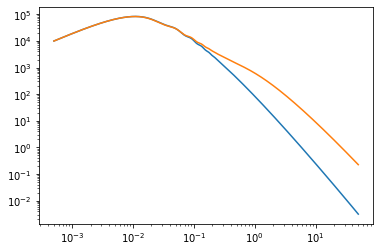

In [136]:
k_arr = np.logspace(np.log10(5e-4),np.log10(50),500)
z_arr = np.array([0.0])

pk_arr_lin = Cosmo_nl.get_pk_array(k_arr, z_arr, k_arr.size, z_arr.size, 0)
pk_arr_nl = Cosmo_nl.get_pk_array(k_arr, z_arr, k_arr.size, z_arr.size, 1)

plt.plot(k_arr, pk_arr_lin)
plt.plot(k_arr, pk_arr_nl)

plt.xscale('log')
plt.yscale('log')

In [137]:
p = 'all_halos'

In [138]:
p + "2"

'all_halos2'

In [34]:
Cosmo_nl.sigma8()

0.7213375506984061

In [8]:
Cosmo_nl.get_current_derived_parameters()

TypeError: get_current_derived_parameters() takes exactly one argument (0 given)

In [3]:
Cosmo_nl.sigma_prime(8,0.2)

-0.07140770726010925

In [36]:
k_grid_points_ascending = np.logspace(np.log10(5.e-4), np.log10(50), 1000)
z_grid_points_ascending = np.arange(0.0, 2.5, step=0.01)

In [52]:
test = Cosmo_nl.get_pk_array(k_grid_points_ascending, z_grid_points_ascending, k_grid_points_ascending.size, z_grid_points_ascending.size, 0).reshape(z_grid_points_ascending.size, k_grid_points_ascending.size)

In [142]:
lol = np.array([[2, 5, 4], [3,3,5], [2,8,5]])

lol

array([[2, 5, 4],
       [3, 3, 5],
       [2, 8, 5]])

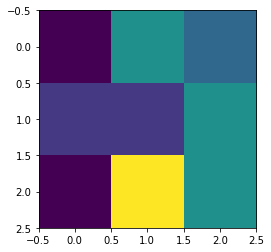

In [143]:
plt.imshow(lol)

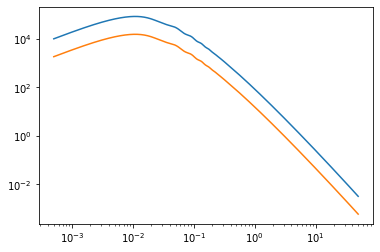

In [54]:
plt.plot(k_grid_points_ascending, test[0,:])
plt.plot(k_grid_points_ascending, test[200,:])
plt.xscale('log')
plt.yscale('log')

In [4]:
Cosmo_nl.get_background()

{'z': array([1.00000000e+14, 9.93048659e+13, 9.86145640e+13, ...,
        1.36446837e-02, 6.55982595e-03, 0.00000000e+00]),
 'proper time [Gyr]': array([7.55850363e-26, 7.66469305e-26, 7.77237432e-26, ...,
        1.35468974e+01, 1.36444568e+01, 1.37356619e+01]),
 'conf. time [Mpc]': array([4.63478500e-09, 4.66752681e-09, 4.70026862e-09, ...,
        1.42389075e+04, 1.42691213e+04, 1.42971760e+04]),
 'H [1/Mpc]': array([2.15754595e+22, 2.12765453e+22, 2.09817724e+22, ...,
        2.34843131e-04, 2.34139466e-04, 2.33494867e-04]),
 'comov. dist.': array([14297.17601364, 14297.17601364, 14297.17601364, ...,
           58.26853854,    28.05469849,     0.        ]),
 'ang.diam.dist.': array([1.42971760e-10, 1.43972562e-10, 1.44980370e-10, ...,
        5.74841850e+01, 2.78718639e+01, 0.00000000e+00]),
 'lum. dist.': array([1.42971760e+18, 1.41977915e+18, 1.40990978e+18, ...,
        5.90635943e+01, 2.82387324e+01, 0.00000000e+00]),
 'comov.snd.hrz.': array([2.67595816e-09, 2.69468987e-09, 2.

In [11]:
Cosmo_nl.get_current_derived_parameters('nonlinear_pk_tilt_at_k_and_z')

TypeError: Deprecated

In [5]:
Cosmo_nl.pk_tilt(0.8,2)

-2.3394049971132302

In [7]:
Cosmo_nl.pk_tilt(0.8,0.2)

-2.3393564465620953

In [6]:
Cosmo_nl.pk_nonlinear_tilt(0.8,2)

-1.3687975135727484

In [8]:
Cosmo_nl.pk_nonlinear_tilt(0.8,0.2)

-1.0714043151298591

In [13]:
from cosmology_utils import *
%load_ext autoreload
%autoreload 2

In [14]:
CosmoClassObject = CosmoClass(Cosmo_nl)

In [7]:
anik_grid_minus = np.loadtxt('../output/P_l80_z30_grids/P_l_z_grid_minus_1step_Omega_cdm.dat')
anik_grid_plus = np.loadtxt('../output/P_l80_z30_grids/P_l_z_grid_plus_1step_Omega_cdm.dat')
#anik_grid_v3 = np.loadtxt('../output/iB_l_z_grid_60l_zlin50_takahashi_v3.txt')

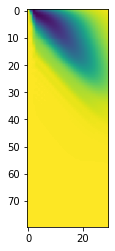

In [8]:
plt.imshow(anik_grid_plus-anik_grid_minus)

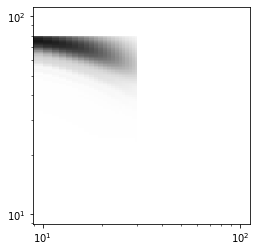

In [30]:
plt.imshow(anik_grid_plus-anik_grid_minus, extent=[0, 30, 0, 80], cmap='gray')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0.01,30)
#plt.ylim(1,80)

#plt.axvline(100, color='red')

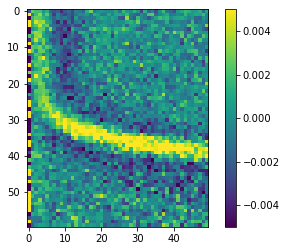

In [143]:
plt.imshow(anik_grid_v1/anik_grid_v2-1,vmin=-0.005,vmax=0.005)
plt.colorbar()

In [115]:
(laurence_grid/anik_grid_v1-1).flatten()

array([ 0.29997461, -0.00051182, -0.00045868, ..., -0.00131575,
        0.00432835, -0.00095999])

In [224]:
anik_grid_tree = np.loadtxt('../output/iB_l_z_grid_70l_zlog30_takahashi_anik_tree.txt')
anik_grid_GM = np.loadtxt('../output/iB_l_z_grid_70l_zlog30_takahashi_anik_GM.txt')
anik_grid_GMRF = np.loadtxt('../output/iB_l_z_grid_70l_zlog30_takahashi_anik_GMRF.txt')
anik_grid_GMRF_v2 = np.loadtxt('../output/iBm_l_z_grid_l80_z25_takahashi_GMRF_integlmax20000_30proc.txt')
anik_grid_GMRF_v3 = np.loadtxt('../output/iBm_l_z_grid_l80_z25_takahashi_GMRF_integlmax20000_30proc_mpusm01.txt')
anik_grid_GMRF_v4 = np.loadtxt('../output/iBm_l_z_grid_l80_z25_takahashi_GMRF_mpusm01_test.txt')
anik_grid_GMRF_v1 = np.loadtxt('../output/iBp_l_z_grid_l80_z25_takahashi_GMRF.txt')


In [252]:
l_array_80 = np.logspace(np.log10(2), np.log10(15000), 80)
l_array_60 = np.logspace(np.log10(2), np.log10(15000), 60)

In [262]:
anik_iBp = np.loadtxt('../output/iBp_l_l80_BIN4_BIN4_BIN4_takahashi_GMRF.txt')
anik_iBm = np.loadtxt('../output/iBm_l_l80_BIN4_BIN4_BIN4_takahashi_GMRF.txt')
anik_iBp_v1 = np.loadtxt('../output/iBp_l_BIN4_BIN4_BIN4_takahashi_GMRF.txt')
anik_iBm_v1 = np.loadtxt('../output/iBm_l_BIN4_BIN4_BIN4_takahashi_GMRF.txt')
anik_iBp_v2 = np.loadtxt('../output/iBp_l_BIN4_BIN4_BIN4_takahashi_GMRF_v2.txt')
anik_iBm_v2 = np.loadtxt('../output/iBm_l_BIN4_BIN4_BIN4_takahashi_GMRF_v2.txt')
anik_iBp_v3 = np.loadtxt('../output/iBp_l_BIN4_BIN4_BIN4_takahashi_GMRF_v3.txt')
anik_iBm_v3 = np.loadtxt('../output/iBm_l_BIN4_BIN4_BIN4_takahashi_GMRF_v3.txt')
anik_iB_cpp = np.loadtxt('../output/test_spectra/iB_222.dat')

In [263]:
anik_iB_cpp.shape

(60, 3)

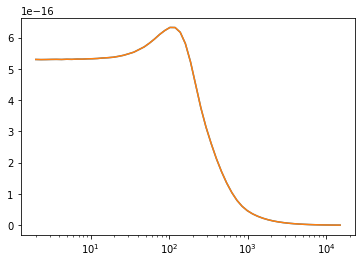

In [264]:
#plt.plot(l_array, np.sum(anik_grid_tree, axis=1))
#plt.plot(l_array, np.sum(anik_grid_GM, axis=1))
#plt.plot(l_array, np.sum(anik_grid_GMRF, axis=1))
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v1, axis=1))

#plt.plot(l_array_80, anik_iBp)
#plt.plot(l_array_60, anik_iBp_v1)
plt.plot(l_array_60, anik_iBp_v2)
plt.plot(l_array_60, anik_iBp_v3)
#plt.plot(anik_iB_cpp[:,0], anik_iB_cpp[:,1])

#plt.plot(anik_iB_cpp[:,0], anik_iBp_v1)
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v2, axis=1))
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v3, axis=1))
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v4, axis=1))
plt.xscale('log')
#plt.yscale('log')

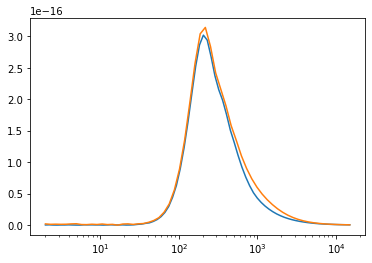

In [219]:
#plt.plot(l_array, np.sum(anik_grid_tree, axis=1))
#plt.plot(l_array, np.sum(anik_grid_GM, axis=1))
#plt.plot(l_array, np.sum(anik_grid_GMRF, axis=1))
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v1, axis=1))
plt.plot(l_array_v1, anik_iBm)
plt.plot(anik_iB_cpp[:,0], anik_iB_cpp[:,2])
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v2, axis=1))
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v3, axis=1))
#plt.plot(l_array_v1, np.sum(anik_grid_GMRF_v4, axis=1))
plt.xscale('log')
#plt.yscale('log')

(-0.001, 0.001)

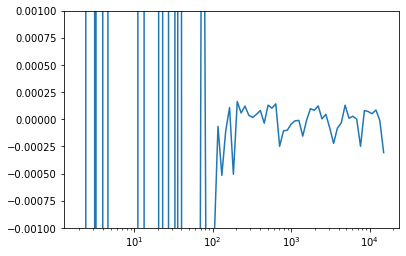

In [194]:
plt.plot(l_array_v2, np.sum(anik_grid_GMRF_v2, axis=1)/np.sum(anik_grid_GMRF_v3, axis=1) - 1)
plt.xscale('log')
plt.ylim(-0.001,0.001)


In [179]:
np.append(np.array([0.0, 0.05]), np.logspace(np.log10(0.1), np.log10(2.1), 23))

array([0.        , 0.05      , 0.1       , 0.11484203, 0.13188693,
       0.15146163, 0.17394162, 0.19975809, 0.22940626, 0.26345481,
       0.30255687, 0.34746246, 0.39903296, 0.45825757, 0.52627232,
       0.60438183, 0.69408439, 0.79710064, 0.91540659, 1.05127155,
       1.20730163, 1.38648975, 1.59227304, 1.82859875, 2.1       ])

In [606]:
k1 = np.ones(5)
k2 = np.ones(5)*2
k3 = np.ones(5)*3

k = np.array([k3,k1,k2]).T
k

array([[3., 1., 2.],
       [3., 1., 2.],
       [3., 1., 2.],
       [3., 1., 2.],
       [3., 1., 2.]])

In [609]:
k.sort(axis=1)
k[:,0]

array([1., 1., 1., 1., 1.])

In [234]:
CosmoClassObject.Pk_nl(np.logspace(-3,2,100), np.array([0])).shape

(1, 100)

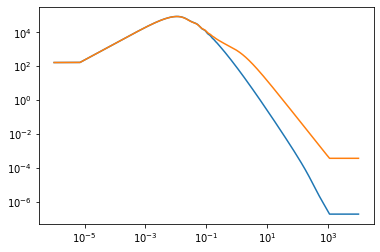

In [244]:
k_arr = np.logspace(-6,4,1000)
plt.plot(k_arr, CosmoClassObject.Pk_lin(k_arr, np.array([0]))[0,:])
plt.plot(k_arr, CosmoClassObject.Pk_nl(k_arr, np.array([0]))[0,:])
plt.xscale('log')
plt.yscale('log')

In [118]:
Cosmo_nl.scale_independent_growth_factor(0.4)

0.8187870971174416

In [111]:
Cosmo_nl.get_background()

{'z': array([1.00000000e+14, 9.93048659e+13, 9.86145640e+13, ...,
        1.36446837e-02, 6.55982595e-03, 0.00000000e+00]),
 'proper time [Gyr]': array([7.55850363e-26, 7.66469305e-26, 7.77237432e-26, ...,
        1.35468974e+01, 1.36444568e+01, 1.37356619e+01]),
 'conf. time [Mpc]': array([4.63478500e-09, 4.66752681e-09, 4.70026862e-09, ...,
        1.42389075e+04, 1.42691213e+04, 1.42971760e+04]),
 'H [1/Mpc]': array([2.15754595e+22, 2.12765453e+22, 2.09817724e+22, ...,
        2.34843131e-04, 2.34139466e-04, 2.33494867e-04]),
 'comov. dist.': array([14297.17601364, 14297.17601364, 14297.17601364, ...,
           58.26853854,    28.05469849,     0.        ]),
 'ang.diam.dist.': array([1.42971760e-10, 1.43972562e-10, 1.44980370e-10, ...,
        5.74841850e+01, 2.78718639e+01, 0.00000000e+00]),
 'lum. dist.': array([1.42971760e+18, 1.41977915e+18, 1.40990978e+18, ...,
        5.90635943e+01, 2.82387324e+01, 0.00000000e+00]),
 'comov.snd.hrz.': array([2.67595816e-09, 2.69468987e-09, 2.

In [49]:
Cosmo_nl.pk_tilt(4.41770079e+02,0.0)

-3.4049837103625418

In [42]:
Cosmo_nl.get_pk_and_k_and_z()[1]

array([6.99438826e-06, 8.80541312e-06, 1.10853583e-05, 1.39556393e-05,
       1.75691090e-05, 2.21181977e-05, 2.78451612e-05, 3.50549810e-05,
       4.41316064e-05, 5.55584008e-05, 6.99438826e-05, 8.80541312e-05,
       1.10853583e-04, 1.39556393e-04, 1.75691090e-04, 2.21181977e-04,
       2.78451612e-04, 3.50549810e-04, 4.41316064e-04, 5.55584008e-04,
       6.99438826e-04, 8.80541312e-04, 1.10853583e-03, 1.39556393e-03,
       1.75691090e-03, 2.21181977e-03, 2.78451612e-03, 3.50549810e-03,
       4.41316064e-03, 5.55584008e-03, 6.99438826e-03, 8.80541312e-03,
       1.10853583e-02, 1.39556392e-02, 1.75690256e-02, 2.21066055e-02,
       2.74579262e-02, 3.19778366e-02, 3.52543469e-02, 3.79549658e-02,
       4.03656022e-02, 4.26135847e-02, 4.47662536e-02, 4.68639642e-02,
       4.89332131e-02, 5.09926679e-02, 5.30562522e-02, 5.51348590e-02,
       5.72373660e-02, 5.93712686e-02, 6.15430915e-02, 6.37586660e-02,
       6.60233222e-02, 6.83420250e-02, 7.07194726e-02, 7.31601689e-02,
      

In [113]:
Cosmo_nl.get_background()['H [1/Mpc]']

array([2.15754595e+22, 2.12765453e+22, 2.09817724e+22, ...,
       2.34843131e-04, 2.34139466e-04, 2.33494867e-04])

In [73]:
Cosmo_nl.get_background()

{'z': array([1.00000000e+14, 9.93048659e+13, 9.86145640e+13, ...,
        1.36446837e-02, 6.55982595e-03, 0.00000000e+00]),
 'proper time [Gyr]': array([7.55850363e-26, 7.66469305e-26, 7.77237432e-26, ...,
        1.35468974e+01, 1.36444568e+01, 1.37356619e+01]),
 'conf. time [Mpc]': array([4.63478500e-09, 4.66752681e-09, 4.70026862e-09, ...,
        1.42389075e+04, 1.42691213e+04, 1.42971760e+04]),
 'H [1/Mpc]': array([2.15754595e+22, 2.12765453e+22, 2.09817724e+22, ...,
        2.34843131e-04, 2.34139466e-04, 2.33494867e-04]),
 'comov. dist.': array([14297.17601364, 14297.17601364, 14297.17601364, ...,
           58.26853854,    28.05469849,     0.        ]),
 'ang.diam.dist.': array([1.42971760e-10, 1.43972562e-10, 1.44980370e-10, ...,
        5.74841850e+01, 2.78718639e+01, 0.00000000e+00]),
 'lum. dist.': array([1.42971760e+18, 1.41977915e+18, 1.40990978e+18, ...,
        5.90635943e+01, 2.82387324e+01, 0.00000000e+00]),
 'comov.snd.hrz.': array([2.67595816e-09, 2.69468987e-09, 2.

In [85]:
Cosmo_nl.get_pk_and_k_and_z()[0].shape

(144, 19)

In [291]:
z_array = np.append(np.array([0.0001, 0.03, 0.07]), np.logspace(np.log10(0.1), np.log10(2.0), 22))
z_array

array([1.00000000e-04, 3.00000000e-02, 7.00000000e-02, 1.00000000e-01,
       1.15333059e-01, 1.33017144e-01, 1.53412740e-01, 1.76935606e-01,
       2.04065246e-01, 2.35354689e-01, 2.71441762e-01, 3.13062086e-01,
       3.61064079e-01, 4.16426245e-01, 4.80277125e-01, 5.53918298e-01,
       6.38850915e-01, 7.36806300e-01, 8.49781241e-01, 9.80078696e-01,
       1.13035474e+00, 1.30367269e+00, 1.50356559e+00, 1.73410818e+00,
       2.00000000e+00])

In [6]:
l_array = np.logspace(np.log10(2), np.log10(15000), 88).astype(int)
l_array = np.logspace(np.log10(2), np.log10(15000), 64).astype(int)

np.unique(l_array).size

60

In [312]:
angles = np.loadtxt('./../data/angular_bins/alpha_angles_arcmins_20_bins.tab')

iZp = np.loadtxt('./../output/iZp_BIN4_BIN4_BIN4_takahashi_GMRF.txt')
iZm = np.loadtxt('./../output/iZm_BIN4_BIN4_BIN4_takahashi_GMRF.txt')
iZp_bin_averaged = np.loadtxt('./../output/iZp_BIN4_BIN4_BIN4_takahashi_GMRF_bin_averaged.txt')
iZm_bin_averaged = np.loadtxt('./../output/iZm_BIN4_BIN4_BIN4_takahashi_GMRF_bin_averaged.txt')

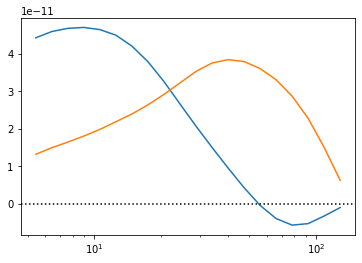

In [325]:
#plt.plot(angles, angles*iZp)
#plt.plot(angles, angles*iZm)
plt.plot(angles, angles*iZp_bin_averaged)
plt.plot(angles, angles*iZm_bin_averaged)
plt.xscale('log')
plt.axhline(0, ls='dotted', c='k')

In [25]:
area_pre_factor = np.loadtxt('../../Integrated_3PCF_theory_results_notebooks_plots/Integrated_shear_3PCF_spectra_theory_folders/Integrated_shear_3PCF_project_II_RF_baryons/takahashi_nonsq_GM_sq7_RF_ell120_iZ_Mss_U70W75W75_cross_zs10_zs16_mc_2e6_x2_220_20000_with_baryons_change_params_bin_averaged/i3pt_area_pre_factors_qag.dat', usecols=[2])

angles = np.loadtxt('../../Integrated_3PCF_theory_results_notebooks_plots/Integrated_shear_3PCF_spectra_theory_folders/Integrated_shear_3PCF_project_II_RF_baryons/takahashi_nonsq_GM_sq7_RF_ell120_iZ_Mss_U70W75W75_cross_zs10_zs16_mc_2e6_x2_220_20000_with_baryons_change_params/iZp_Re_111.dat', usecols=[0])

iZp_111_GMRF_bsr_cpp = np.loadtxt('../../Integrated_3PCF_theory_results_notebooks_plots/Integrated_shear_3PCF_spectra_theory_folders/Integrated_shear_3PCF_project_II_RF_baryons/takahashi_bsr_nonsq_GM_sq7_RF_ell150_iZ_Mss_U70W75W75_cross_zs10_zs16_mc_1e6_x2_200_20000/iZp_Re_111.dat', usecols=[1])
iZp_111_GMRF_cpp = np.loadtxt('../../Integrated_3PCF_theory_results_notebooks_plots/Integrated_shear_3PCF_spectra_theory_folders/Integrated_shear_3PCF_project_II_RF_baryons/takahashi_nonsq_GM_sq7_RF_ell120_iZ_Mss_U70W75W75_cross_zs10_zs16_mc_2e6_x2_220_20000_with_baryons_change_params/iZm_Re_111.dat', usecols=[1])
iZp_111_GMRF_python = np.loadtxt('../output/iZm_zs1_zs1_zs1_takahashi_l80_z25_GMRF_bin_averaged.txt')

iZp_111_GM_bsr_cpp = np.loadtxt('../../Integrated_3PCF_theory_results_notebooks_plots/Integrated_shear_3PCF_spectra_theory_folders/Integrated_shear_3PCF_project_II_RF_baryons/takahashi_bsr_GM_ell150_iZ_Mss_U70W75W75_cross_zs10_zs16_mc_1e6_x2_200_20000/iZm_Re_222.dat', usecols=[1])
iZp_111_GM_cpp = np.loadtxt('../../Integrated_3PCF_theory_results_notebooks_plots/Integrated_shear_3PCF_spectra_theory_folders/Integrated_shear_3PCF_project_I/takahashi_B_GM_157_iZkxi_U70W75W75_cross_zs10_zs16_1e7_20000_sigma8z/iZp_Re_222.dat', usecols=[1])
iZp_111_GM_python = np.loadtxt('../output/iZp_zs2_zs2_zs2_takahashi_GM_bin_averaged.txt')


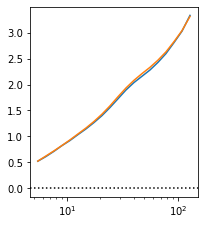

In [26]:
pre_factor = 1e8
plt.figure(figsize=(3,3.5))
#plt.plot(angles, pre_factor*angles*iZp_111_GMRF_bsr_cpp / area_pre_factor)
plt.plot(angles, pre_factor*angles*iZp_111_GMRF_cpp / area_pre_factor)
plt.plot(angles, pre_factor*angles*iZp_111_GMRF_python / area_pre_factor)

#plt.plot(angles, pre_factor*angles*iZp_111_GM_bsr_cpp / area_pre_factor)
#plt.plot(angles, pre_factor*angles*iZp_111_GM_cpp / area_pre_factor)
#plt.plot(angles, pre_factor*angles*iZp_111_GM_python / area_pre_factor)
plt.xscale('log')
#plt.ylim(-4,7)
plt.axhline(ls='dotted', c='k')

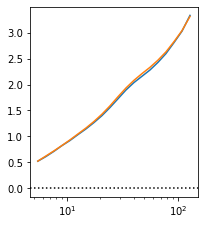

In [27]:
pre_factor = 1e8
plt.figure(figsize=(3,3.5))
#plt.plot(angles, pre_factor*angles*iZp_111_GMRF_bsr_cpp / area_pre_factor)
plt.plot(angles, pre_factor*angles*iZp_111_GMRF_cpp / area_pre_factor)
plt.plot(angles, pre_factor*angles*iZp_111_GMRF_python / area_pre_factor)

#plt.plot(angles, pre_factor*angles*iZp_111_GM_bsr_cpp / area_pre_factor)
#plt.plot(angles, pre_factor*angles*iZp_111_GM_cpp / area_pre_factor)
#plt.plot(angles, pre_factor*angles*iZp_111_GM_python / area_pre_factor)
plt.xscale('log')
#plt.ylim(-4,7)
plt.axhline(ls='dotted', c='k')

In [98]:
def calculate_size_10_array(arr):
    assert(arr.size % 100 == 0)
    arr_splits = np.split(arr, 100)
    final_arr = np.zeros(100)
    for i in range(len(arr_splits)):
        final_arr[i] = np.mean(arr_splits[i])
    return final_arr

In [99]:
samples = np.random.normal(0,1,50000)

In [100]:
samples_2 = calculate_size_10_array(samples)

In [101]:
samples_2.size

100

In [102]:
np.mean(samples)

0.0024864307777652996

In [103]:
np.mean(samples_2)

0.0024864307777653

In [104]:
np.var(samples, ddof=1) / (samples.size)

1.988478155384887e-05

In [105]:
np.var(samples_2, ddof=1) / (samples_2.size)

2.0714711703383468e-05

In [115]:
samples_var = np.zeros(5000)
samples_2_var = np.zeros(5000)

for i in range(5000):
    samples = np.random.normal(0,1,50000)
    samples_2 = calculate_size_10_array(samples)

    samples_var[i] = np.var(samples, ddof=1) / (samples.size)
    samples_2_var[i] = np.var(samples_2, ddof=1) / (samples_2.size)

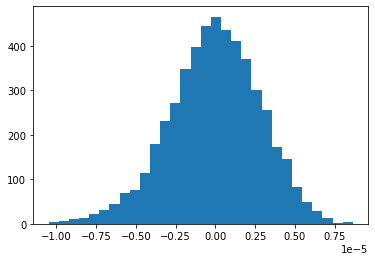

In [117]:
plt.hist(samples_var-samples_2_var, bins=30);
#plt.hist(samples_2_var);

In [118]:
np.mean(samples_var-samples_2_var)

-4.972068130522072e-08

In [120]:
np.mean(samples_var)

1.9998210477896716e-05

In [46]:
from scipy.stats import sem

In [47]:
sem(samples)

0.013968866142261982

In [48]:
sem(samples_2)

0.013793209716213823

In [49]:
1/64*22/3

0.11458333333333333

In [2]:
DESY3_nofz = np.loadtxt('../data/nofz/DESY3_nofz/DES_Y3.txt')

In [18]:
DESY3_nofz[:][DESY3_nofz[:,0] == 0][:,1:]

array([[ 0.0000e+00,  0.0000e+00],
       [ 5.0000e-03,  1.3350e-05],
       [ 1.5000e-02,  7.8800e-04],
       [ 2.5000e-02,  1.6080e-03],
       [ 3.5000e-02,  2.3120e-03],
       [ 4.5000e-02,  3.0290e-03],
       [ 5.5000e-02,  4.9000e-03],
       [ 6.5000e-02,  1.1030e-02],
       [ 7.5000e-02,  1.2000e-02],
       [ 8.5000e-02,  1.1894e-02],
       [ 9.5000e-02,  1.2100e-02],
       [ 1.0500e-01,  1.3590e-02],
       [ 1.1500e-01,  1.6460e-02],
       [ 1.2500e-01,  1.7600e-02],
       [ 1.3500e-01,  1.7750e-02],
       [ 1.4500e-01,  1.8340e-02],
       [ 1.5500e-01,  2.0390e-02],
       [ 1.6500e-01,  2.3850e-02],
       [ 1.7500e-01,  2.5970e-02],
       [ 1.8500e-01,  2.6380e-02],
       [ 1.9500e-01,  2.6600e-02],
       [ 2.0500e-01,  2.7070e-02],
       [ 2.1500e-01,  2.7650e-02],
       [ 2.2500e-01,  2.8030e-02],
       [ 2.3500e-01,  2.8320e-02],
       [ 2.4500e-01,  2.8290e-02],
       [ 2.5500e-01,  2.7570e-02],
       [ 2.6500e-01,  2.6430e-02],
       [ 2.7500e-01,

In [35]:
SBIN1 = DESY3_nofz[:][DESY3_nofz[:,0] == 0][:202,1:]
SBIN2 = DESY3_nofz[:][DESY3_nofz[:,0] == 1][:202,1:]
SBIN3 = DESY3_nofz[:][DESY3_nofz[:,0] == 2][:202,1:]
SBIN4 = DESY3_nofz[:][DESY3_nofz[:,0] == 3][:202,1:]

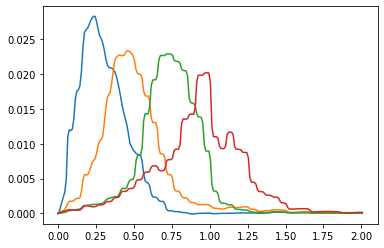

In [36]:
plt.plot(SBIN1[:,0],SBIN1[:,1])
plt.plot(SBIN2[:,0],SBIN2[:,1])
plt.plot(SBIN3[:,0],SBIN3[:,1])
plt.plot(SBIN4[:,0],SBIN4[:,1])

In [40]:
np.savetxt('../data/nofz/DESY3_nofz/nofz_DESY3_source_SBIN1.tab', SBIN1)
np.savetxt('../data/nofz/DESY3_nofz/nofz_DESY3_source_SBIN2.tab', SBIN2)
np.savetxt('../data/nofz/DESY3_nofz/nofz_DESY3_source_SBIN3.tab', SBIN3)
np.savetxt('../data/nofz/DESY3_nofz/nofz_DESY3_source_SBIN4.tab', SBIN4)